In [1]:
import torch
!pip install --upgrade -q accelerate bitsandbytes
!pip install git+https://github.com/huggingface/transformers.git

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-lcd_u485
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-lcd_u485
  Resolved https://github.com/huggingface/transformers.git to commit 061c2c4c387f05350aa63b284f7910d69588c79f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
from transformers import AutoProcessor, LlavaForConditionalGeneration, BitsAndBytesConfig

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
)

original_model_id = "llava-hf/llava-1.5-7b-hf"
model_id = "akibc123/llava_for_circuit_netlist"
model = LlavaForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    quantization_config=bnb_config,
    low_cpu_mem_usage=True,
)
# processor is not changed so we still load from the original model repo
processor = AutoProcessor.from_pretrained(original_model_id)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/80.0M [00:00<?, ?B/s]

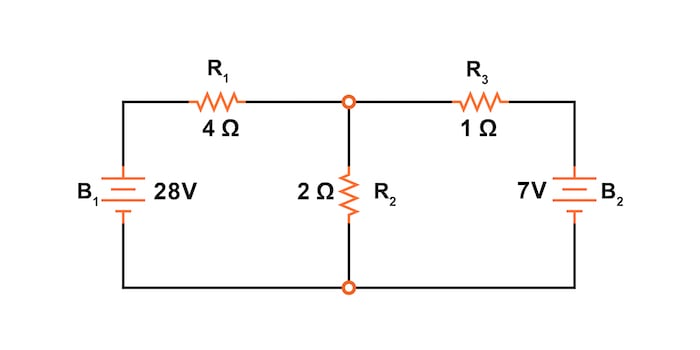

In [12]:
import requests
from PIL import Image
from io import BytesIO
url = 'https://www.allaboutcircuits.com/uploads/thumbnails/Figure_1._Circuit_for_explaining_the_branch_current_method_.jpg'
response = requests.get(url)
image1 = Image.open(BytesIO(response.content))

#image1 = Image.open('https://eepower.com/uploads/articles/understanding-dc-circuit-capacitor-behavior-fig1.jpg')

display(image1)


In [13]:
prompts = [
            "USER: <image>\n Generate a netlist for the circut\nASSISTANT:"
]

inputs = processor(image1, prompts, padding=True, return_tensors="pt").to("cuda")
for k,v in inputs.items():
  print(k,v.shape)

input_ids torch.Size([1, 22])
attention_mask torch.Size([1, 22])
pixel_values torch.Size([1, 3, 336, 336])


In [14]:
output = model.generate(**inputs, max_new_tokens= 50)
generated_text = processor.batch_decode(output, skip_special_tokens=True)
for text in generated_text:
  print(text.split("ASSISTANT:")[-1])

 Multiple dc sources v1 1 0 dc 24 v2 3 0 dc 12 r1 1 2 4 r2 2 3 7 r3 2 0 1
